In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, homogeneity_score, completeness_score, \
    fowlkes_mallows_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

In [3]:
filepath = '/'.join(os.getcwd().split('/')[0:-1]) + 'data/ai_ready/sitkin_statistics.csv'
df = pd.read_csv(filepath_or_buffer=filepath)
df.head(3)

,mean,max,min,median,range,std,var,spec_mean,spec_max,spec_min,...,spec_std,spec_var,speclog_mean,speclog_max,speclog_min,speclog_median,speclog_range,speclog_std,speclog_var,state
0,-2.045739,1659.079530,-1318.335883,-6.963337,2977.415414,371.791134,138228.647271,10.392417,995.277247,0.004666,...,31.456352,989.502099,0.433941,2.997944,-2.331057,0.297929,5.329001,0.661548,0.437646,before
1,-43.245231,1800.918051,-1867.272921,-56.748376,3668.190972,476.115885,226686.335511,12.038669,1081.727088,0.010802,...,40.854324,1669.075788,0.473613,3.034118,-1.966483,0.329268,5.000601,0.658096,0.433090,before
2,-34.465366,2031.091640,-2252.112966,-32.267577,4283.204606,548.338617,300675.238931,12.984918,1236.088867,0.011445,...,49.401049,2440.463664,0.500578,3.092050,-1.941383,0.366436,5.033433,0.640550,0.410304,before


In [5]:
#count entries per state, want to be close to balanced
df.value_counts(subset='state')

state
before    1204
after     1196
Name: count, dtype: int64

In [7]:
#encode class labels for later modeling
le = LabelEncoder()
le.fit(df['state'])

df_ready = df.drop(columns=['state']).copy()
df_ready['state'] = le.transform(df['state'])

print([0,1])
print(le.classes_)

[0, 1]
['after' 'before']


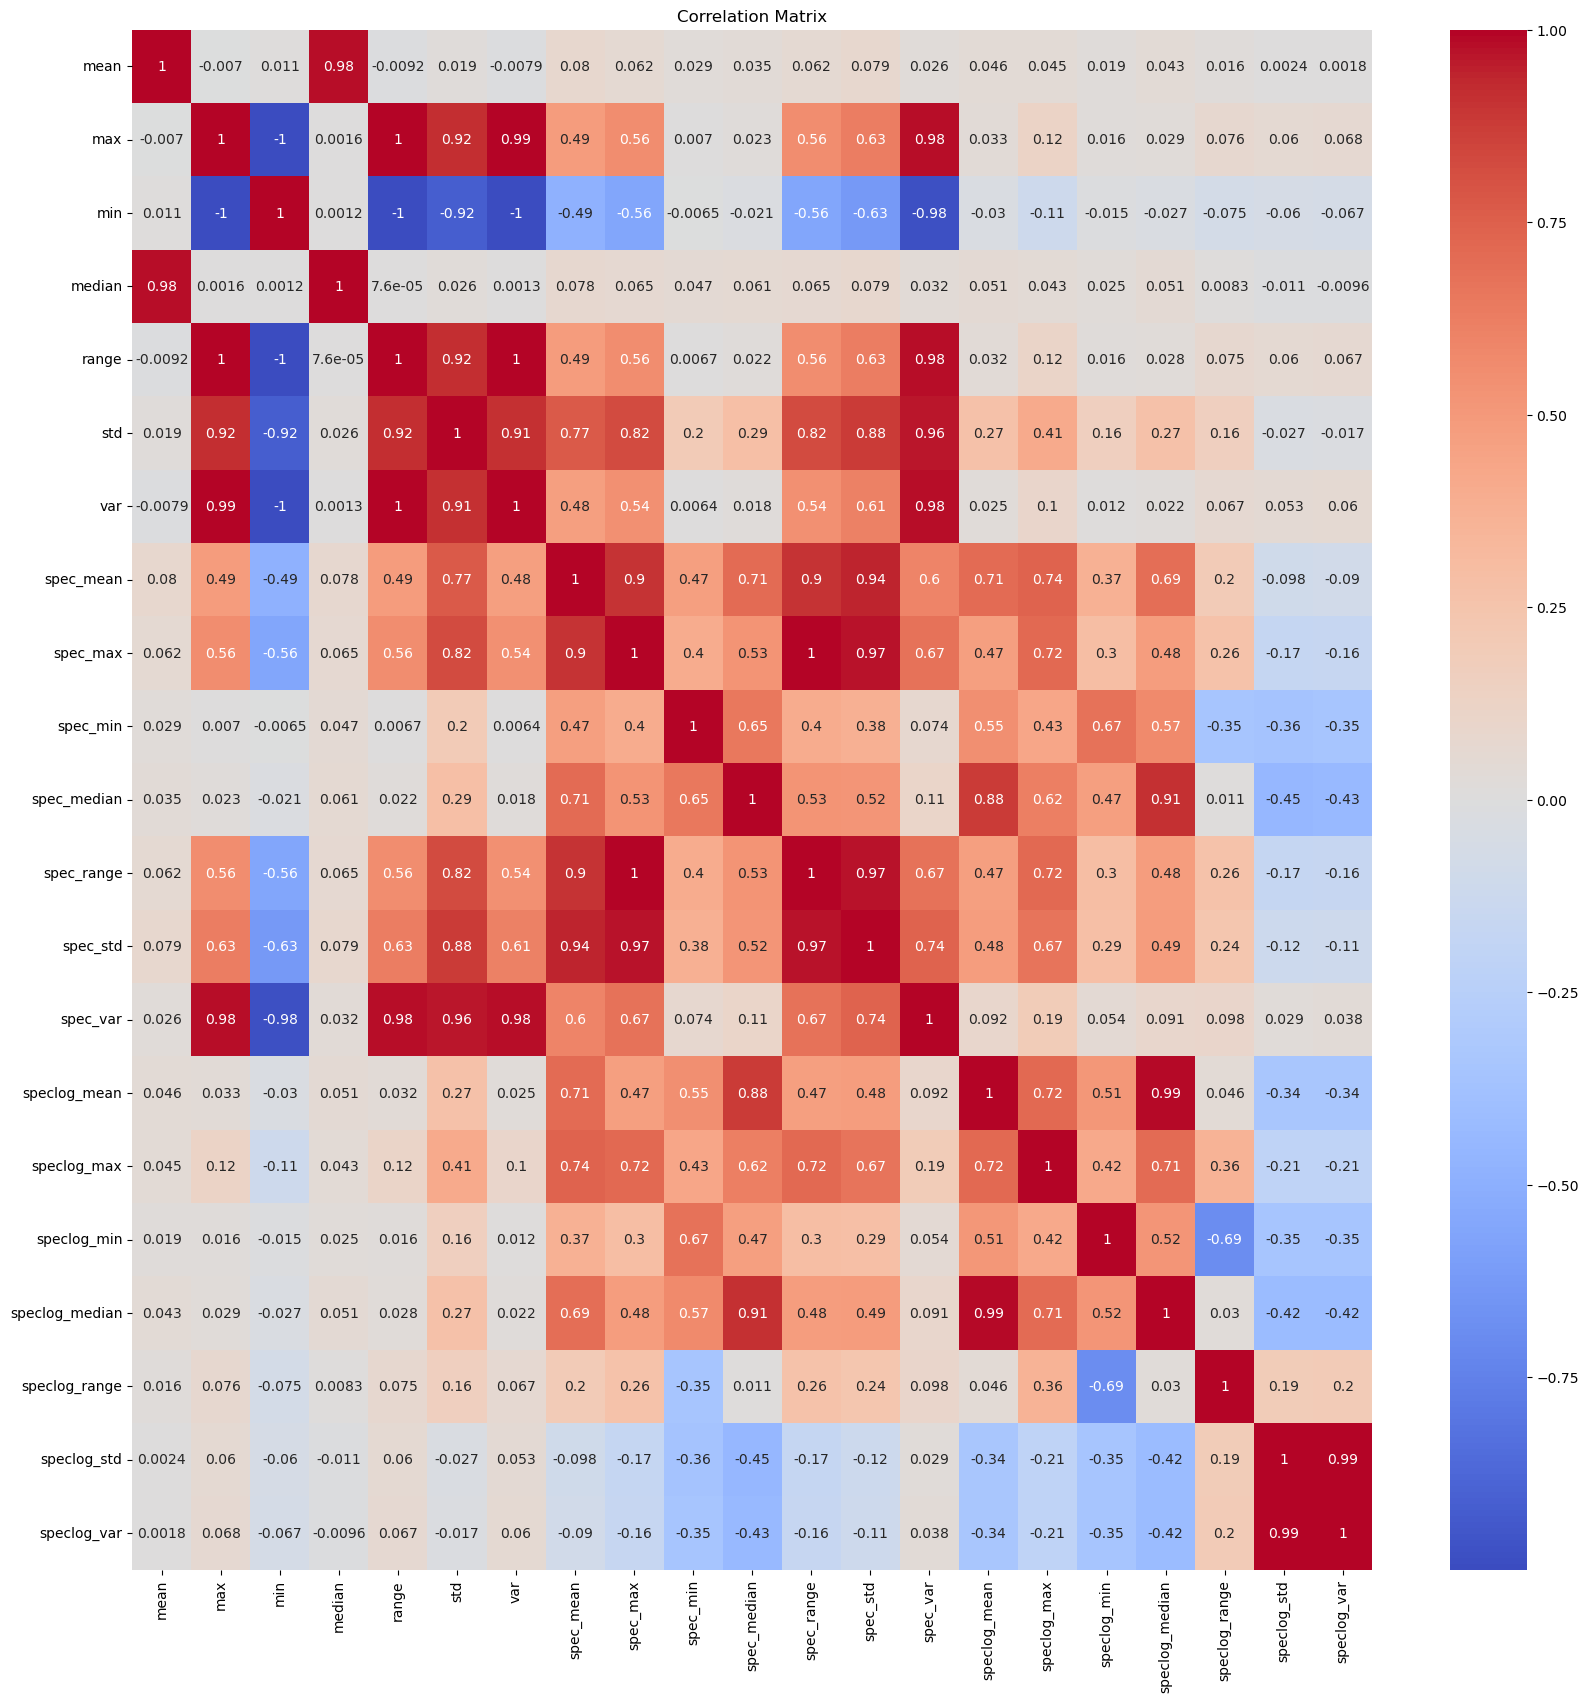

In [11]:
#cross correlation map to look at which stats might be redundant
plt.figure(figsize=(20,20))
sns.heatmap(df.drop(columns=['state']).corr(), cmap='coolwarm', center=0, annot=True)
plt.title('Correlation Matrix');

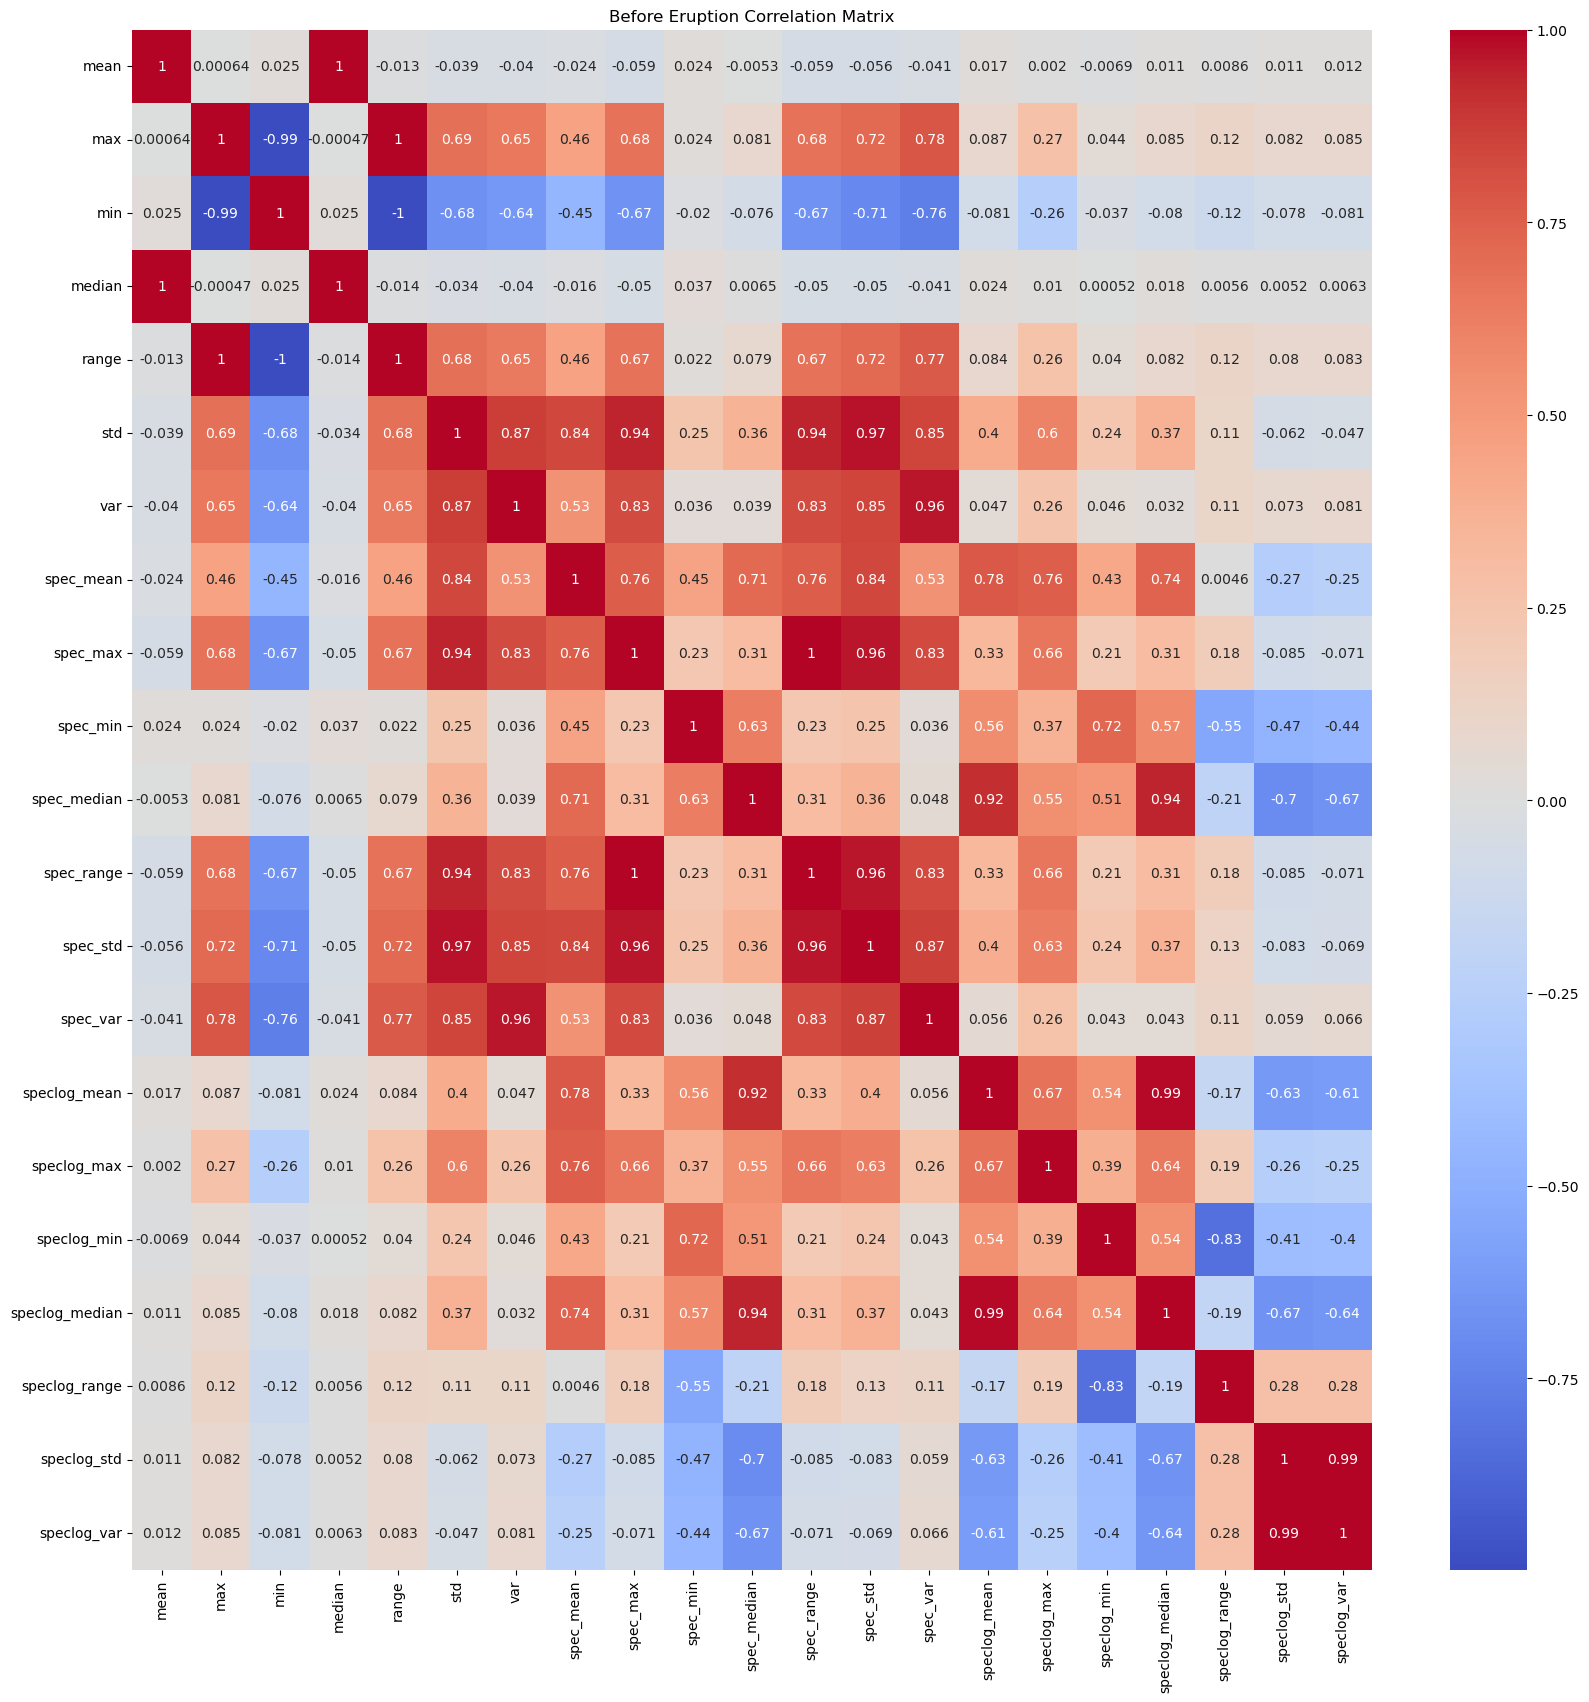

In [13]:
#cross correlation map to look at which stats might be redundant
before_df = df.query('state == "before"')

plt.figure(figsize=(20,20))
sns.heatmap(before_df.drop(columns=['state']).corr(), cmap='coolwarm', center=0, annot=True)
plt.title('Before Eruption Correlation Matrix');

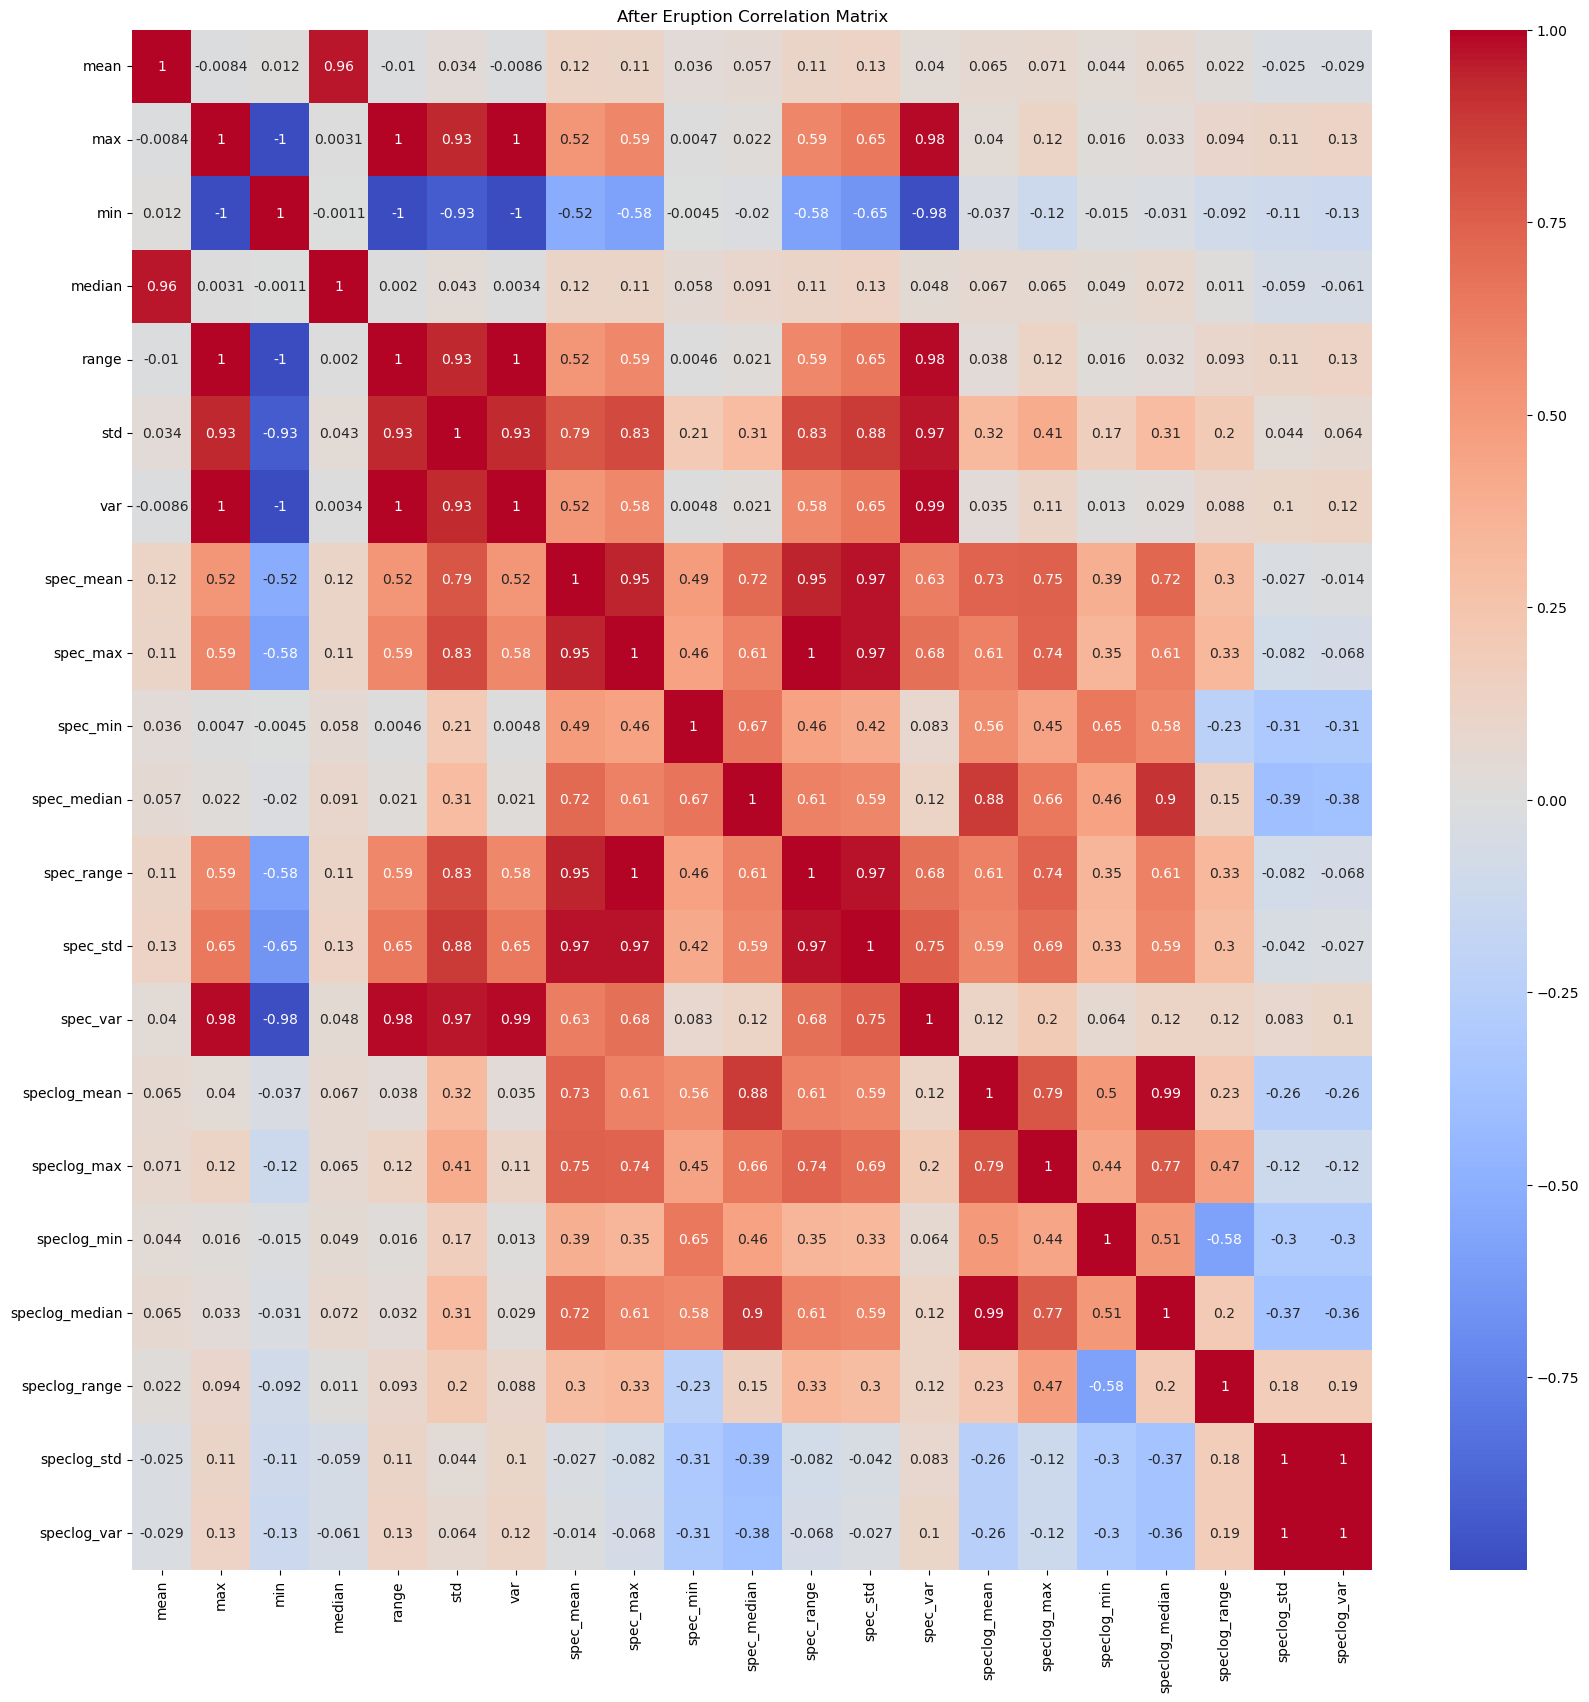

In [15]:
#cross correlation map to look at which stats might be redundant
after_df = df.query('state == "after"')

plt.figure(figsize=(20,20))
sns.heatmap(after_df.drop(columns=['state']).corr(), cmap='coolwarm', center=0, annot=True)
plt.title('After Eruption Correlation Matrix');

[0.429831   0.66443608 0.76549216 0.8576435  0.92236317 0.95842178
 0.97785841 0.99153554 0.99518128 0.99744937 0.99843803 0.9989302
 0.99934847 0.99962951 0.99980522 0.99991512 0.99999151 1.
 1.         1.         1.        ]
CPU times: total: 31.2 ms
Wall time: 33.4 ms


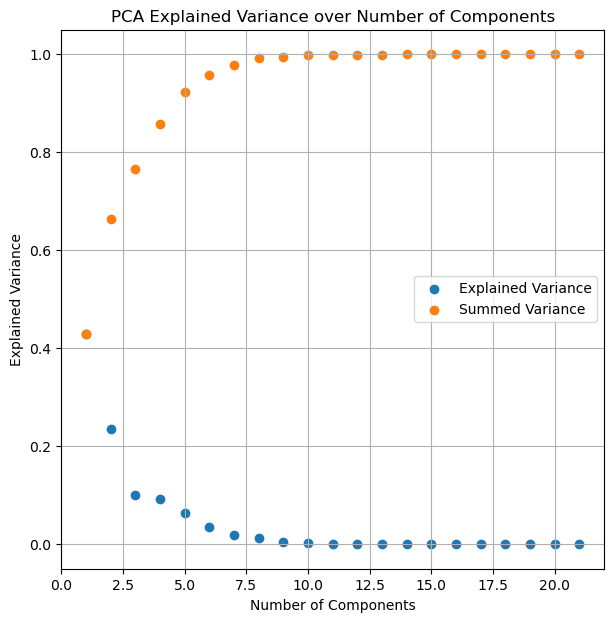

In [27]:
%%time
#standardize variable values
variables = df.keys()[0:-1]
scaler = StandardScaler()
scaled_wl = scaler.fit_transform(df_ready[variables])

#Doing PCA on Wavelength Columns
pca = PCA()
pca.fit(scaled_wl)

#plot explained variances
y = pca.explained_variance_ratio_
pca_sum = np.cumsum(y)
x = np.arange(len(y)) + 1
plt.figure(figsize=(7,7))
plt.scatter(x, y, label='Explained Variance')
plt.scatter(x, pca_sum, label='Summed Variance')
plt.title('PCA Explained Variance over Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.legend()
plt.grid()
print(pca_sum);

In [91]:
print(scaled_wl.shape)

(2400, 21)


In [31]:
%%time
#Doing PCA using 6 components
pca = PCA(n_components=6)
volcano_pca = pca.fit_transform(scaled_wl)
print(volcano_pca)

[[ 0.04965516 -0.50420376  0.04039515 -0.12270911  0.225059   -0.50358056]
 [ 0.45902507 -1.10476344 -0.66886367 -0.1984328   0.9004084  -0.32349344]
 [ 0.76960048 -1.44264561 -0.665426   -0.08206149  0.65570369 -0.33415656]
 ...
 [-1.59760307  0.39475316 -2.50908103  1.71764213 -1.15466501  1.63004176]
 [-1.44914406  0.70171135 -1.3871602   0.77339067 -2.31210927  1.50134327]
 [-1.53984825  0.60829122 -1.90877843  1.24514728 -1.62153782  1.44972948]]
CPU times: total: 46.9 ms
Wall time: 35.6 ms


In [ ]:
#PCA Computational Time - PCA takes longer using 6 components than 21 components because each component of the second analysis is a weighted sum of the original 21 statistics. However, this more computationally expensive and more precise method is only about 7% slower than the original PCA.

In [35]:
#creating dataframe with PC axes, and saving separate state label list
true_labels = df_ready.state
df_final = pd.DataFrame(columns=['pc1','pc2','pc3','pc4','pc5','pc6'])
df_final['pc1'] = volcano_pca[:,0]
df_final['pc2'] = volcano_pca[:,1]
df_final['pc3'] = volcano_pca[:,2]
df_final['pc4'] = volcano_pca[:,3]
df_final['pc5'] = volcano_pca[:,4]
df_final['pc6'] = volcano_pca[:,5]

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# classifiers from sklearns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


In [39]:
#set up data and true labels again
X = scaler.fit_transform(df_final)
Y = true_labels

#same features list
features = df_final.keys().to_numpy()
features

array(['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6'], dtype=object)

In [41]:
#split into train and test sets, chose 80/20%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [43]:
#KNN Training

In [45]:
%%time
#Model definition
knn = KNeighborsClassifier()

#Training
knn.fit(X_train, Y_train)


CPU times: total: 15.6 ms
Wall time: 9.71 ms


KNeighborsClassifier()

In [ ]:
KNN Training only takes a total of 9.71 ms to train on 100 days worth of data, a very efficient ML framework.

In [47]:
%%time
#Prediction on Test
Y_pred = knn.predict(X_test)

CPU times: total: 0 ns
Wall time: 36.3 ms


In [ ]:
#KNN takes 0 computational time to predict

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       241
           1       0.84      0.82      0.83       239

    accuracy                           0.84       480
   macro avg       0.84      0.84      0.84       480
weighted avg       0.84      0.84      0.84       480



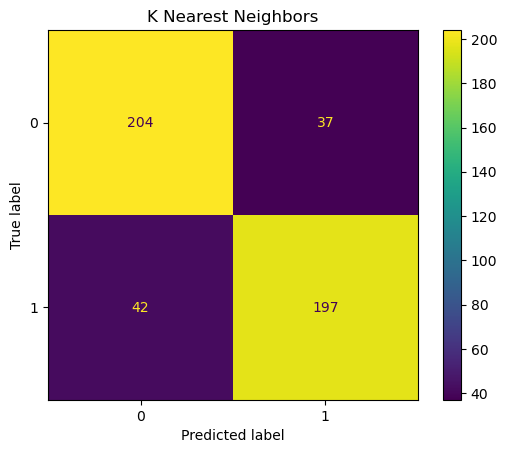

In [49]:
#Evaluation: classification report, save precision, recall, fscore, and accuracy
print(classification_report(Y_test, Y_pred))
knn_dict = classification_report(Y_test, Y_pred, output_dict=True)
ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred)).plot()
plt.title('K Nearest Neighbors');

In [ ]:
#KNN is shown to have a high precision and F1 score, while also being computationally inexpensive

In [51]:
%%time
#define parameter grid
param_grid = {'n_neighbors':np.arange(2,15,1)}

#Run grid search and print optimal settings
grid_search = GridSearchCV(KNeighborsClassifier(), 
                           param_grid=param_grid, cv=5) 
grid_search.fit(X_train, Y_train) 
print(grid_search.best_params_) 

{'n_neighbors': 5}
CPU times: total: 1.58 s
Wall time: 3.34 s


In [ ]:
#Shows the optimal number of neighbours is 5, tuning takes significantly longer than training

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       241
           1       0.84      0.84      0.84       239

    accuracy                           0.84       480
   macro avg       0.84      0.84      0.84       480
weighted avg       0.84      0.84      0.84       480

CPU times: total: 46.9 ms
Wall time: 99 ms


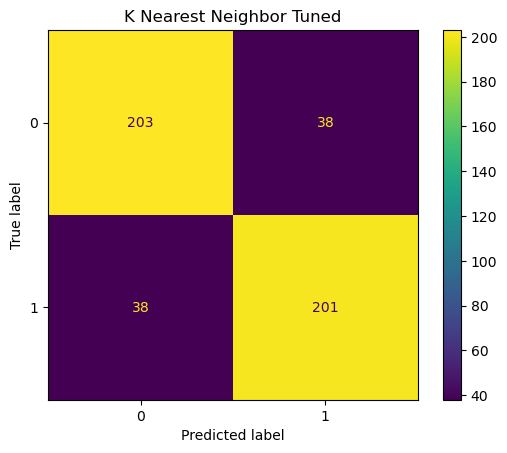

In [53]:
%%time
#use ideal parameters and test model
knn_tuned = KNeighborsClassifier(n_neighbors=14) 
knn_tuned.fit(X_train, Y_train) 
y_pred_grid = knn_tuned.predict(X_test) 
print(classification_report(y_pred_grid, Y_test))

knn_dict = classification_report(Y_test, y_pred_grid, output_dict=True)
ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred_grid)).plot()
plt.title('K Nearest Neighbor Tuned');

In [ ]:
#Prediction takes only a small fraction of the amount of time as tuning, and increases precision and F1 score slightly

In [57]:
%%time
#plot model's predictions over whole time series
times = np.arange(len(df_final)+1) / 24 #time in days
ys = np.array([0,1])
predictions = knn_tuned.predict(df_final.to_numpy()).reshape((1,len(df_final)))
legends = ['After', 'Before']
#find eruption index (where values switch from 1 to 0)
eruption_index = np.where(np.roll(true_labels,1)!=true_labels)[0][1]
eruption_index /= 24

CPU times: total: 109 ms
Wall time: 151 ms


In [ ]:
#Applying trained model to dataset only takes a small fraction of the time needed to train, test and tune KNN

In [59]:
#Random Forest Training

In [61]:
%%time
#Model definition
rf = RandomForestClassifier()

#Training
rf.fit(X_train, Y_train)

#Prediction on Test
Y_pred = rf.predict(X_test)

#Evaluation: classification report, save precision, recall, fscore, and accuracy
print(classification_report(Y_test, Y_pred))
rf_dict = classification_report(Y_test, Y_pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       241
           1       0.85      0.88      0.87       239

    accuracy                           0.86       480
   macro avg       0.86      0.86      0.86       480
weighted avg       0.86      0.86      0.86       480

CPU times: total: 125 ms
Wall time: 565 ms


In [ ]:
#RF takes over 10x longer to train, but has higher precision and F1 scores, and given that the data size and small enough, the time difference is negliable

In [63]:
%%time
#define parameter grid
param_grid = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9, 12], 
    'max_leaf_nodes': [3, 6, 9, 12]}

#Run grid search and print optimal settings
grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid, cv=5) 
grid_search.fit(X_train, Y_train) 
print(grid_search.best_params_) 

{'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 12, 'n_estimators': 50}
CPU times: total: 3min 8s
Wall time: 4min 44s


In [ ]:
#RF again takes almost 10x as long to tune/optimize as KNN

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       221
           1       0.86      0.79      0.82       259

    accuracy                           0.82       480
   macro avg       0.82      0.82      0.82       480
weighted avg       0.82      0.82      0.82       480

CPU times: total: 141 ms
Wall time: 430 ms


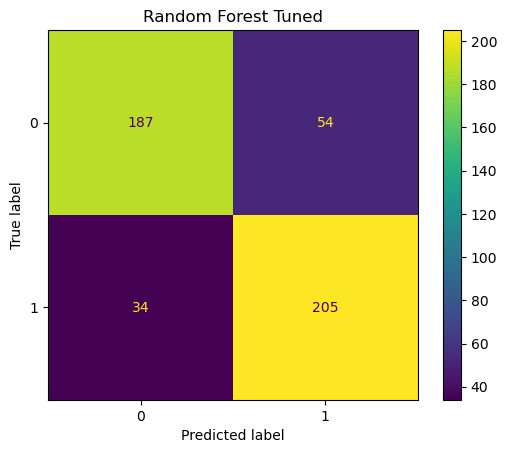

In [64]:
%%time
#use ideal parameters and test model
rf_tuned = RandomForestClassifier(max_depth=12, 
                                    max_features="log2", 
                                    max_leaf_nodes=12, 
                                    n_estimators=50) 
rf_tuned.fit(X_train, Y_train) 
y_pred_grid = rf_tuned.predict(X_test) 
print(classification_report(y_pred_grid, Y_test)) 

rf_dict = classification_report(Y_test, y_pred_grid, output_dict=True)
ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred_grid)).plot()
plt.title('Random Forest Tuned');

In [ ]:
#Precision and F1 score drop after tuning, meaning that the model may be overtrained/overfitted

In [67]:
%%time
#plot model's predictions over whole time series
times = np.arange(len(df_final)+1) / 24 #time in days
ys = np.array([0,1])
predictions = rf_tuned.predict(df_final.to_numpy()).reshape((1,len(df_final)))
legends = ['After', 'Before']

#find eruption index (where values switch from 1 to 0)
eruption_index = np.where(np.roll(true_labels,1)!=true_labels)[0][1]
eruption_index /= 24


CPU times: total: 0 ns
Wall time: 10.7 ms


In [ ]:
#Applying model to data again takes very little time

In [69]:
#Gaussian Naive Bayes

              precision    recall  f1-score   support

           0       0.88      0.56      0.69       241
           1       0.68      0.92      0.78       239

    accuracy                           0.74       480
   macro avg       0.78      0.74      0.74       480
weighted avg       0.78      0.74      0.74       480

CPU times: total: 31.2 ms
Wall time: 66.4 ms


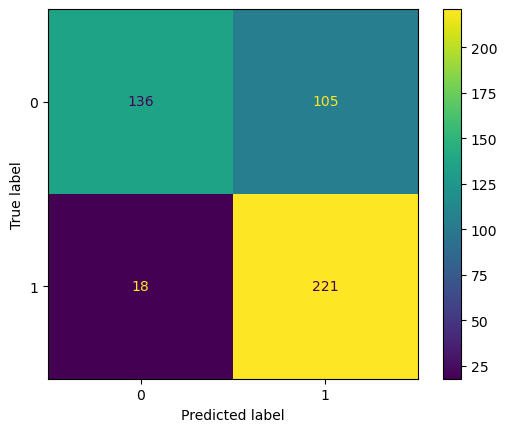

In [71]:
%%time
#Model definition
gnb = GaussianNB()

#Training
gnb.fit(X_train, Y_train)

#Prediction on Test
Y_pred = gnb.predict(X_test)

#Evaluation: classification report, save precision, recall, fscore, and accuracy
print(classification_report(Y_test, Y_pred))
gnb_dict = classification_report(Y_test, Y_pred, output_dict=True)
ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred)).plot()

In [ ]:
#GNB takes slighter longer to train and test than KNN, much shorter than RF. However, its precision and F1 scores are in general lower than both the others.

In [73]:
%%time
#define parameter grid
param_grid = {'var_smoothing':np.logspace(-1,-10, num=100)}

#Run grid search and print optimal settings
grid_search = GridSearchCV(GaussianNB(), 
                           param_grid=param_grid, cv=5) 
grid_search.fit(X_train, Y_train) 
print(grid_search.best_params_)

{'var_smoothing': 0.008111308307896872}
CPU times: total: 734 ms
Wall time: 1.88 s


In [ ]:
#Takes roughly the same amount of time to tune as KNN, again an order of magnitude shorter than RF

In [75]:
%%time
#use ideal parameters and test model
gnb_tuned = GaussianNB(var_smoothing=0.002310129700083158) 
gnb_tuned.fit(X_train, Y_train) 
y_pred_grid = gnb_tuned.predict(X_test) 
print(classification_report(y_pred_grid, Y_test)) 

              precision    recall  f1-score   support

           0       0.56      0.88      0.69       154
           1       0.92      0.68      0.78       326

    accuracy                           0.74       480
   macro avg       0.74      0.78      0.74       480
weighted avg       0.81      0.74      0.75       480

CPU times: total: 0 ns
Wall time: 10.5 ms


In [77]:
%%time
#plot model's predictions over whole time series
times = np.arange(len(df_final)+1) / 24 #time in days
ys = np.array([0,1])
predictions = gnb_tuned.predict(df_final.to_numpy()).reshape((1,len(df_final)))
legends = ['After', 'Before']

#find eruption index (where values switch from 1 to 0)
eruption_index = np.where(np.roll(true_labels,1)!=true_labels)[0][1]
eruption_index /= 24

CPU times: total: 0 ns
Wall time: 2 ms


In [ ]:
#Applying to datset for forward modeling again only takes a fraction of the time

In [79]:
#Support Vector Machine

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       241
           1       0.83      0.87      0.85       239

    accuracy                           0.85       480
   macro avg       0.85      0.85      0.85       480
weighted avg       0.85      0.85      0.85       480

CPU times: total: 78.1 ms
Wall time: 263 ms


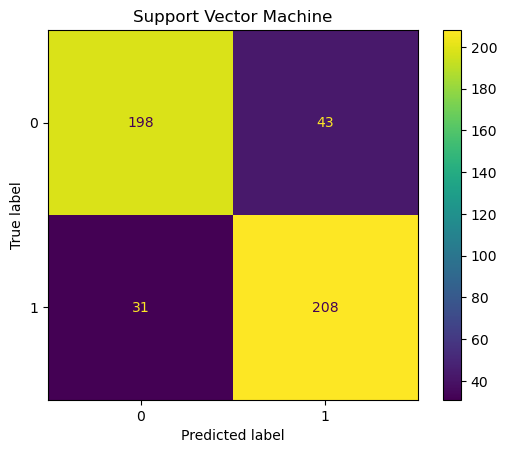

In [81]:
%%time
#Model definition
svm = SVC()

#Training
svm.fit(X_train, Y_train)

#Prediction on Test
Y_pred = svm.predict(X_test)

#Evaluation: classification report, save precision, recall, fscore, and accuracy
print(classification_report(Y_test, Y_pred))
svm_dict = classification_report(Y_test, Y_pred, output_dict=True)
ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred)).plot()
plt.title('Support Vector Machine');

In [ ]:
#Support vector takes around twice the time of KNN and GNB, and around half the time of RF for the initial training and testing, with similar precision and F1 scores

In [83]:
%%time
#define parameter grid
param_grid = {'C': np.logspace(-1, 3, 20),  
              'gamma': np.logspace(0, -4, 20)}

#Run grid search and print optimal settings
grid_search = GridSearchCV(SVC(), 
                           param_grid=param_grid, cv=5) 
grid_search.fit(X_train, Y_train) 
print(grid_search.best_params_)

{'C': 1.8329807108324356, 'gamma': 1.0}
CPU times: total: 3min 37s
Wall time: 4min 57s


In [ ]:
#SVM takes about the same amount of time to tune as RF

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       242
           1       0.86      0.86      0.86       238

    accuracy                           0.86       480
   macro avg       0.86      0.86      0.86       480
weighted avg       0.86      0.86      0.86       480

CPU times: total: 78.1 ms
Wall time: 300 ms


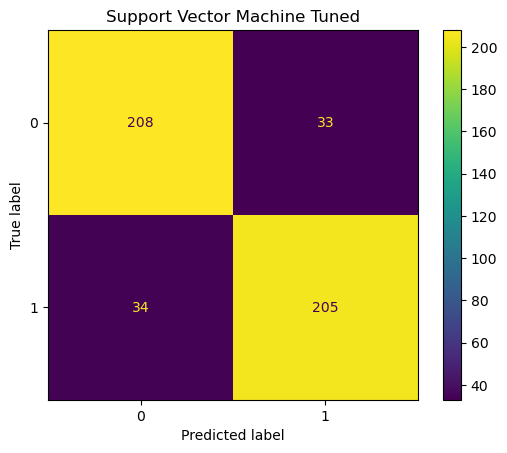

In [85]:
%%time
#use ideal parameters and test model
svm_tuned = SVC(C=1.8329807108324356,
                 gamma=1) 
svm_tuned.fit(X_train, Y_train) 
y_pred_grid = svm_tuned.predict(X_test) 
print(classification_report(y_pred_grid, Y_test)) 

svm_dict = classification_report(Y_test, y_pred_grid, output_dict=True)
ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred_grid)).plot()
plt.title('Support Vector Machine Tuned');

In [ ]:
#Tuning does increase model precision and F1 scores by a small but noticeable amount

In [87]:
%%time
#plot model's predictions over whole time series
times = np.arange(len(df_final)+1) / 24 #time in days
ys = np.array([0,1])
predictions = svm_tuned.predict(df_final.to_numpy()).reshape((1,len(df_final)))
legends = ['After', 'Before']

#find eruption index (where values switch from 1 to 0)
eruption_index = np.where(np.roll(true_labels,1)!=true_labels)[0][1]
eruption_index /= 24

CPU times: total: 141 ms
Wall time: 310 ms


In [ ]:
#Applying tuned SVM model to data takes longer than other ML methods, but still a negligible amount of time

In [ ]:
#The model's computational time for the initial training and testing steps, as well as applying the finished models to the dataset,
#did vary somewhat, but on scales almost impercetable to humans considering how short the involved timescales were, despite the huge amount of
#spectrogram data that was involved in the analysis. However, model tuning of paramters is what really set the different models apart as far as
#computational time is concerned. KNN used around 3 seconds to tune 1 parameter, RF used 5 miutes to tune 4 parameters, GNB used 2 seconds to tune
#1 parameter, and SVM used 5 minutes to tune 2 parameters. The number of parameters being tuned mattered much less to computational time than the type
#of the model being tuned.